# 1. Data Processing & Feature Engineering

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("behrad3d/nasa-cmaps")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Yoni\.cache\kagglehub\datasets\behrad3d\nasa-cmaps\versions\1


In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict


# train1
data = []
data1_path = path + "\\CMaps\\train_FD001.txt"

with open(data1_path, 'r') as f:
    for line in f:
        # print(line.strip().split('\t'))
        row = list(map(float, line.strip().split(' ')))
        data.append(row)

data1 = torch.tensor(data)

max_time_per_unit = defaultdict(int)
for row in data:
    unit_number, time = row[0], row[1]
    max_time_per_unit[unit_number] = max(max_time_per_unit[unit_number], time)

labels1 = []
for row in data:
    unit_number, time = row[0], row[1]
    max_time = max_time_per_unit[unit_number]
    labels1.append(max_time - time)

In [3]:
class EngineDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [4]:
train1_dataset = EngineDataset(data1, labels1)

dataloader = torch.utils.data.DataLoader(train1_dataset, batch_size=128, shuffle=False)


# 2. RUL Prediction Model 

In [5]:
import torch.nn as nn
import torch.nn.functional as F


# 2k loss
# class RULModel(nn.Module):
#     def __init__(self):
#         super(RULModel, self).__init__()
#         self.fc1 = nn.Linear(26, 26 * 4)
#         self.fc2 = nn.Linear(26 * 4, 26)
#         self.fc3 = nn.Linear(26, 1)

#     def forward(self, x):
#         x = self.fc1(x)
#         x = self.fc2(x)
#         x = self.fc3(x)
#         return x

class RULModel(nn.Module):
    def __init__(self):
        super(RULModel, self).__init__()
        self.lstm1 = torch.nn.LSTM(input_size=26, hidden_size=128, num_layers=2, batch_first=True)
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
    

    def forward(self, x):
        x, _ = self.lstm1(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

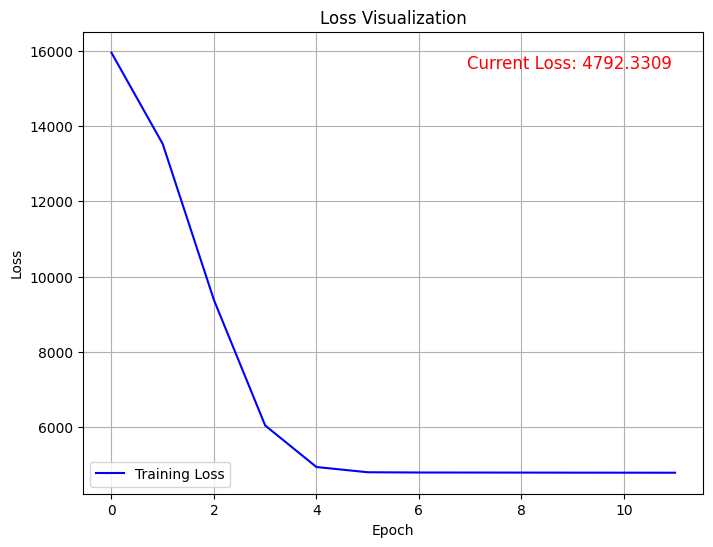

KeyboardInterrupt: 

In [6]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Initialize the model, loss function, optimizer, and device
model = RULModel()
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
epochs = 1000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# List to store epoch losses for visualization
epoch_losses = []

# Create a single progress bar for all epochs (can be commented out if not needed)
with tqdm(total=epochs, desc="Training Progress", unit="epoch") as pbar:
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0

        for data, labels in dataloader:
            data, labels = data.to(device, dtype=torch.float), labels.to(device, dtype=torch.float)

            # Forward pass
            pred = model(data)
            loss = loss_fn(pred.view(-1), labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Accumulate loss
            epoch_loss += loss.item()

        # Calculate average loss for the epoch
        avg_epoch_loss = epoch_loss / len(dataloader)
        epoch_losses.append(avg_epoch_loss)

        # Update progress bar (can be commented out if using chart visualization)
        # pbar.set_postfix({"Epoch Loss": f"{avg_epoch_loss:.4f}"})
        # pbar.update(1)

        # Plot loss graph dynamically
        clear_output(wait=True)  # Clear the output for live updating
        plt.figure(figsize=(8, 6))
        plt.plot(epoch_losses, label="Training Loss", color="blue")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Loss Visualization")
        plt.legend()
        plt.grid()

        # Add current loss annotation to the graph        
        plt.text(0.95, 0.95, f"Current Loss: {avg_epoch_loss:.4f}",
                color="red", fontsize=12, ha="right", va="top", transform=plt.gca().transAxes)

        # Display the plot
        plt.show()
